<a href="https://colab.research.google.com/github/adimyth/interesting_stuff/blob/master/model_interpretation/cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==2.0

# Class Activation Maps

CAMs are a simple & effective way of visualizing the CNN networks. It allows us to visualize which part of the image get's most activated for a particular class.

There's a Global Average Pooling layer after the last convolution block followed by a dense layer.

![CAM](https://cdn-images-1.medium.com/fit/t/1600/480/1*hXdqemUHnAlwKUIcl-4PDA.jpeg)

Suppose after the last conv block, the output is of size *8x8x256* i.e. 256 filters of size 8x8. After GAP, the output will be a 256 sized vector, which is then passed to a dense layer with *n* (10 for MNIST) units. Thus each edge from the 256 units to a particular class C represents the weight of that corresponding filter for class C.

Let us assume that the CNN output of size 8x8x256 is represented by the matrix A and the weight matrix from the 256 units (flattened layer) to 24 classes is W. Thus W is of size 256x24. If we multiply A with W then we will obtain a matrix B of size 8x8x24.

>B = A.W


If the actual class label for an example is C, then taking the value of *B[:,:,C]* will return a 8x8 matrix which is nothing but a color-map (or heat-map) for class label C. Thus *B[:,:,C]* represents the weighted sum of all 256 filters of size 8x8 for class label C.

## Importing Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from vis.utils import utils

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model

In [114]:
tf.__version__

'2.0.0'

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [7]:
print(y_train.shape, y_test.shape)

(60000,) (10000,)


In [8]:
y_train[0]

5

In [9]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
print(X_train.shape)
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],X_test.shape[2],1))
print(X_test.shape)
X_train = X_train/255
X_test  = X_test/255
X_train = X_train.astype('float')
X_test  = X_test.astype('float')

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [10]:
X_train[0].shape

(28, 28, 1)

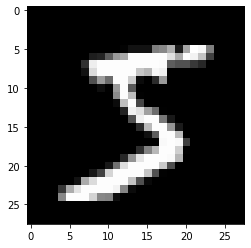

In [11]:
img = X_train[0]
img = img.reshape((28, 28))
plt.imshow(img, cmap="gray")

In [0]:
np.random.seed(42)

## Modelling (with maxpooling)

The models need to be tweaked so that, there's always a Global Average Pooling(GAP) layer after the last convolution block, followed by a Dense layer with softmax activation.

In [0]:
model = Sequential()
model.add(Conv2D(16, input_shape=(28,28,1), kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128,kernel_size=(3,3), activation='relu', padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(10,activation='softmax'))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 3, 3, 128)        

In [21]:
model.input

<tf.Tensor 'conv2d_4_input:0' shape=(None, 28, 28, 1) dtype=float32>

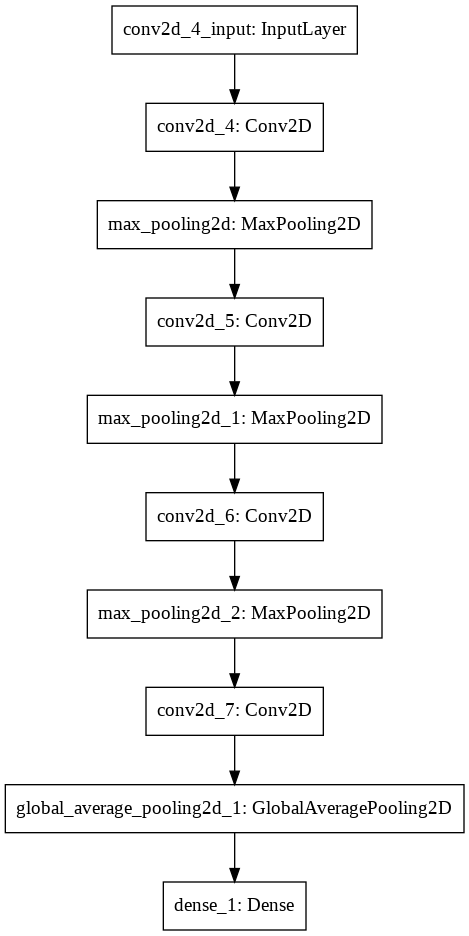

In [22]:
plot_model(model)

In [0]:
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [24]:
model.fit(X_train, y_train, epochs=5, batch_size=64)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 50s 827us/sample - loss: 0.3095 - accuracy: 0.9021
Epoch 2/5
60000/60000 [==============================] - 49s 815us/sample - loss: 0.0911 - accuracy: 0.9711
Epoch 3/5
60000/60000 [==============================] - 48s 801us/sample - loss: 0.0657 - accuracy: 0.9787
Epoch 4/5
60000/60000 [==============================] - 48s 805us/sample - loss: 0.0488 - accuracy: 0.9847
Epoch 5/5
60000/60000 [==============================] - 48s 800us/sample - loss: 0.0401 - accuracy: 0.9875


In [0]:
model.save('trained_model.h5')

## CAM Prediction

Model to get the output of the last convolution block and classification prediction

In [0]:
# 1. conv_feat: model.layers[-3].output would give us the output of the last convolution block
# 2. class_res: model.layers[-1].output would give us classification output
cam_model  = Model(inputs=model.input, 
                   outputs=(model.layers[-3].output, model.layers[-1].output))


In [27]:
cam_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4_input (InputLayer)  [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0     

In [28]:
print(X_test.shape, X_test[0].shape)

(10000, 28, 28, 1) (28, 28, 1)


In [0]:
test_img = np.expand_dims(X_test[0], axis=0)

In [32]:
test_img.shape

(1, 28, 28, 1)

In [0]:
conv_feat, class_res = cam_model.predict(test_img)

In [36]:
print(conv_feat.shape, class_res.shape)

(1, 3, 3, 128) (1, 10)


### Classification

In [37]:
class_res

array([[2.4327006e-11, 7.5945055e-09, 2.0224364e-09, 1.6624096e-08,
        1.3987581e-11, 4.3548545e-10, 7.7247957e-19, 1.0000000e+00,
        4.2868216e-11, 5.6191734e-08]], dtype=float32)

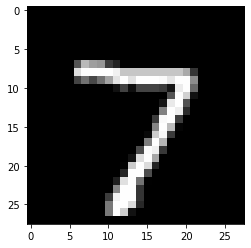

In [42]:
plt.imshow(X_test[0][:,:,0], cmap="gray")

In [39]:
pred_class = np.argmax(class_res)
pred_class

7

### Convolution Feature

In [43]:
conv_feat.shape

(1, 3, 3, 128)

In [44]:
conv_feat[0]

array([[[ 1.3976736 ,  0.        ,  0.        , ...,  1.4314015 ,
          0.        ,  0.8809805 ],
        [ 0.        ,  0.        ,  0.        , ...,  1.0234108 ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  3.3145494 ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          3.6205187 ,  0.        ],
        [ 2.9651701 ,  0.        ,  0.        , ...,  0.        ,
          5.413895  ,  0.        ],
        [ 9.76308   ,  0.        ,  0.        , ...,  0.        ,
          5.01201   , 10.676265  ]],

       [[ 0.        ,  0.        ,  4.151062  , ...,  0.        ,
          7.612549  , 10.032908  ],
        [11.579339  ,  0.        ,  0.6804625 , ...,  0.        ,
          7.249631  , 14.146056  ],
        [ 8.438627  ,  0.77505976,  0.5874276 , ...,  0.        ,
          8.616303  ,  9.321023  ]]], dtype=float32)

Since, the convolution feature map of the input of size *28x28* is *3x3*, we resize the output feature map to the original image size, so as easy to visualize.

In [0]:
height_roomout = X_train.shape[1]/conv_feat.shape[1]
width_roomout  = X_train.shape[2]/conv_feat.shape[2]
 
cam_features = scipy.ndimage.zoom(conv_feat[0], (height_roomout, width_roomout, 1), order=2)

In [73]:
cam_features.shape

(28, 28, 128)

In [86]:
print(height_roomout, width_roomout)

9.333333333333334 9.333333333333334


### GAP Layer
Getting GAP layer weights

In [0]:
gap_weights = model.layers[-1].get_weights()[0]

In [75]:
gap_weights.shape

(128, 10)

In [0]:
cam_output = np.dot(cam_features, gap_weights)

In [79]:
cam_output.shape

(28, 28, 10)

Visualizing the feature map for 7th class

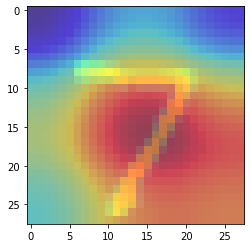

In [85]:
plt.imshow(X_test[0][:,:,0], alpha=0.5)
plt.imshow(cam_output[:, :, 7], cmap="jet", alpha=0.5)
plt.show()

Here, the visualization is not very "correct", as it focuses most on the centre part of the image. 
<br><br><br>
Maybe it would help if we don't use maxpool as then the output feature map would be of the same size as that of the input image(28x28), however that would greatly increase the training size & is not feasible for larger dimension images.

## Modelling (without maxpool)

In [0]:
model = Sequential()
model.add(Conv2D(16, input_shape=(28,28,1), kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(128,kernel_size=(3,3), activation='relu', padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(10,activation='softmax'))

In [88]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
global_average_pooling2d_2 ( (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 98,442
Trainable params: 98,442
Non-trainable params: 0
__________________________________________________

**Notice that the output of the last convolutional feature map is same as the input image**

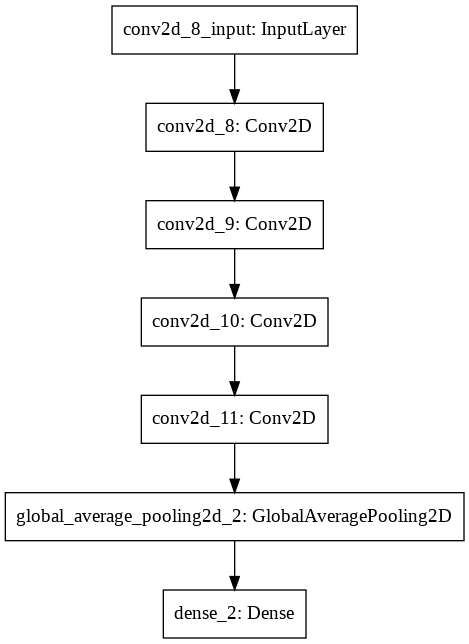

In [90]:
plot_model(model)

In [0]:
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [92]:
model.fit(X_train, y_train, epochs=3, batch_size=64)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 596s 10ms/sample - loss: 0.9976 - accuracy: 0.6652
Epoch 2/3
60000/60000 [==============================] - 574s 10ms/sample - loss: 0.4005 - accuracy: 0.8815
Epoch 3/3
60000/60000 [==============================] - 552s 9ms/sample - loss: 0.2773 - accuracy: 0.9187


In [0]:
model.save('trained_model_without_maxpool.h5')

## CAM Prediction

Model to get the output of the last convolution block and classification prediction

In [0]:
# 1. conv_feat: model.layers[-3].output would give us the output of the last convolution block
# 2. class_res: model.layers[-1].output would give us classification output
cam_model  = Model(inputs=model.input, 
                   outputs=(model.layers[-3].output, model.layers[-1].output))


In [95]:
cam_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8_input (InputLayer)  [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
global_average_pooling2d_2 ( (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290

In [0]:
test_img = np.expand_dims(X_test[0], axis=0)

In [0]:
conv_feat, class_res = cam_model.predict(test_img)

In [98]:
print(conv_feat.shape, class_res.shape)

(1, 28, 28, 128) (1, 10)


### Classification

In [99]:
class_res

array([[6.5375747e-07, 5.3884941e-07, 5.2906962e-05, 4.5078045e-06,
        5.1624347e-08, 2.3197019e-06, 2.9841245e-09, 9.9953818e-01,
        3.6860424e-08, 4.0081909e-04]], dtype=float32)

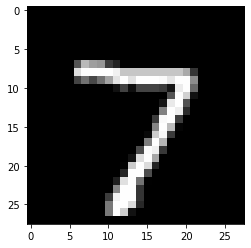

In [100]:
plt.imshow(X_test[0][:,:,0], cmap="gray")

In [101]:
pred_class = np.argmax(class_res)
pred_class

7

### Convolution Feature

In [102]:
conv_feat.shape

(1, 28, 28, 128)

Since, the convolution feature map of the input of size *28x28* is *3x3*, we resize the output feature map to the original image size, so as easy to visualize.

### GAP Layer
Getting GAP layer weights

In [0]:
gap_weights = model.layers[-1].get_weights()[0]

In [104]:
gap_weights.shape

(128, 10)

In [0]:
cam_output = np.dot(conv_feat[0], gap_weights)

In [106]:
cam_output.shape

(28, 28, 10)

Visualizing the feature map for 7th class

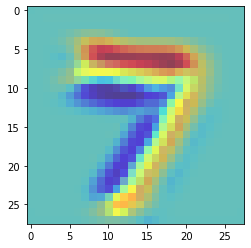

In [107]:
plt.imshow(X_test[0][:,:,0], alpha=0.5)
plt.imshow(cam_output[:, :, 7], cmap="jet", alpha=0.5)
plt.show()

This looks lot better, as it gives a clear indication where the network is looking & is able to map the conv feature map without the input image properly

## Using the `keras-vis` library

In [0]:
!pip install keras-vis

In [0]:
import os
import tempfile
import keras
from vis.visualization import visualize_cam
from tensorflow.keras.initializers import glorot_uniform

In [0]:
# selecting the last layer
layer_idx = -1

In [0]:
model = tf.keras.models.load_model("trained_model_without_maxpool.h5")

In [0]:
# swap softmax with linear
model.layers[layer_idx].activation = keras.activations.linear

In [0]:
model_path = os.path.join(tempfile.gettempdir(), next(tempfile._get_candidate_names()) + '.h5')
try:
  model.save(model_path)
  model = tf.keras.models.load_model(model_path, custom_objects={'GlorotUniform': glorot_uniform()})
finally:
        os.remove(model_path)

In [139]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
global_average_pooling2d_2 ( (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 98,442
Trainable params: 98,442
Non-trainable params: 0
__________________________________________________

In [0]:
penultimate_layer_idx = -3
class_idx  = 7

In [142]:
grad_top1  = visualize_cam(model, layer_idx, class_idx, test_img, 
                           penultimate_layer_idx = penultimate_layer_idx,
                           backprop_modifier=None,
                           grad_modifier=None)

NameError: ignored

Looks like the support for CAM visualization has been removed from the `vis` library as I could not find the code for it in the [official repository](https://github.com/raghakot/keras-vis)